<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/classic/dt-intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning using Decisicon Trees

## Exericse I: Getting familiar with Colab Notebooks

* notebooks are made up out of text and code cells
* they can be executed in any order, but are typically supposed to be executed in order
* execute cells by clicking into them and then type shift+return
* execute all the code cells until you see "stop here"
* make the model predict your risk category, i.e. for your age and speed of car

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.xkcd()
plt.style.use('ggplot')

# Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [2]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   103k      0 --:--:-- --:--:-- --:--:--  102k


In [3]:
!head insurance-customers-1500.csv

speed;age;miles;group
98.0;44.0;25.0;1
118.0;54.0;24.0;1
111.0;26.0;34.0;0
97.0;25.0;10.0;2
114.0;38.0;22.0;1
130.0;55.0;34.0;0
118.0;40.0;51.0;0
143.0;42.0;34.0;1
120.0;41.0;42.0;2


In [0]:
import pandas as pd
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [5]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [6]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


## First important concept: You train a machine with your data to make it learn the relationship between some input data and a certain label - this is called supervised learning

In [0]:
# we deliberately decide this is going to be our label, it is often called lower case y
y = df['group']

In [8]:
y.head()

0    1
1    1
2    0
3    2
4    1
Name: group, dtype: int64

In [0]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [10]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [0]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.to_numpy()

### We restrict ourselves to two dimensions for now

Because this is all we really can visualize in 2d

In [0]:
import numpy as np

# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

# https://matplotlib.org/users/colormaps.html
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py
cmap = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

font_size=25
title_font_size=40

def meshGrid(x_data, y_data):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 100
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=300, proba=False, prediction=True, 
                   legend=False # colab has old version of matplotlib, does not support
                  ):
    xx,yy = meshGrid(x_data, y_data)
    fig, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T).sample(n_samples, random_state=42)
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=100, marker='o', edgecolors='k')

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    if legend:
      class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
      ax.add_artist(class_legend)
    
    return ax, scatter


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


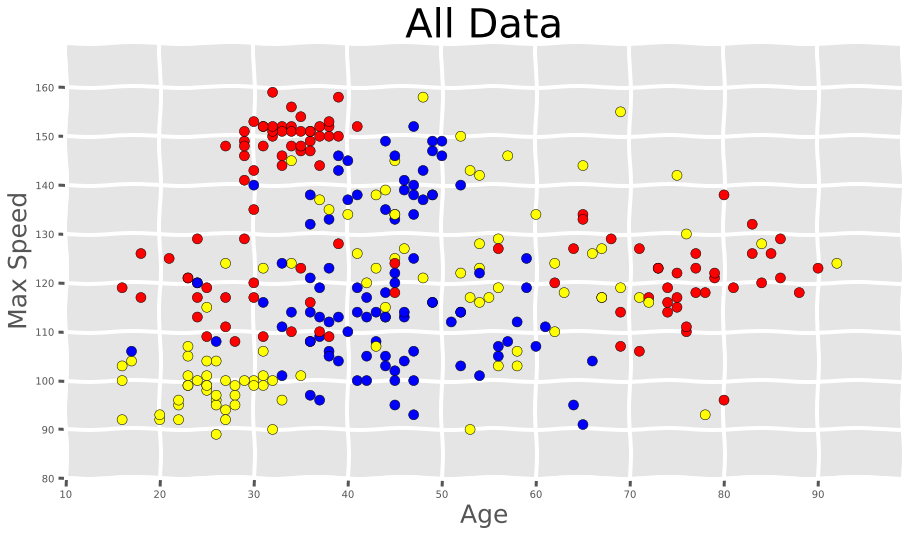

In [13]:
plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data");

In [14]:
# just two dimensions
X[:, :2]

array([[ 98.,  44.],
       [118.,  54.],
       [111.,  26.],
       ...,
       [138.,  41.],
       [100.,  31.],
       [100.,  58.]])

In [15]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
%time clf.fit(X[:, :2], y)

CPU times: user 2.34 ms, sys: 94 µs, total: 2.44 ms
Wall time: 2.44 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [16]:
input = [[100.0, 48.0]]
clf.predict(input)

array([1])

# Stop here

## Exercise II: Getting your feet wet fighting overfitting

## Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/generalization.jpg'>

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1200, 3), (1200,), (300, 3), (300,))

In [0]:
assert X_train.shape == (len(X) * (1 - 0.2), 3)
assert y_train.shape == (len(X) * (1 - 0.2),) 
assert X_test.shape == (len(X) * 0.2, 3)
assert y_test.shape == (len(X) * 0.2, )

In [0]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

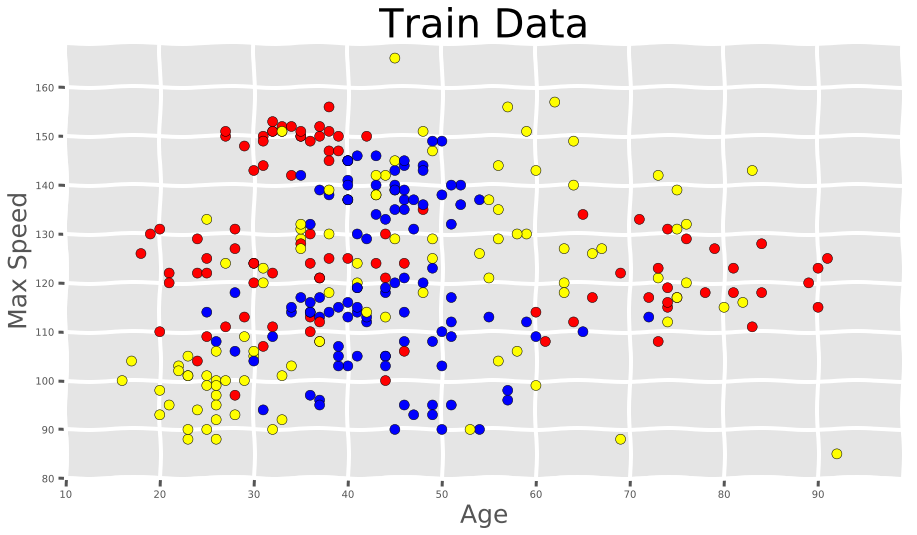

In [20]:
plotPrediction(None, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train, title="Train Data");

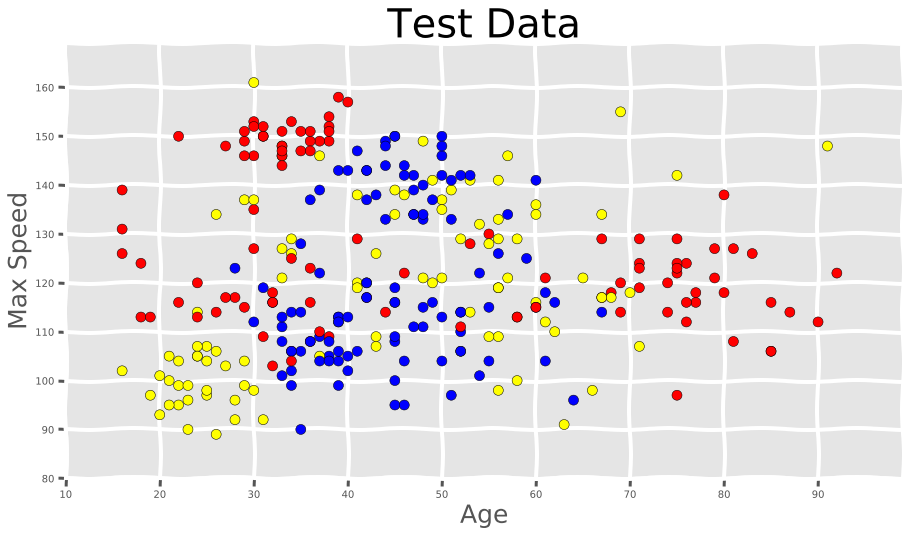

In [21]:
plotPrediction(None, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, title="Test Data");

### What is the best split?

* assign a category to each node containing a certain set of samples
* use a metric (Gini or Entropy) to decide how good a node would be based on that category
* sum up weighted metric for both child nodes
* optimize the split for that summed metric

https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/


In [22]:
clf = DecisionTreeClassifier()
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 2.69 ms, sys: 891 µs, total: 3.58 ms
Wall time: 12.7 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [23]:
# we perform at most 18 splits of our data until we make a decision where the data point belongs

clf.tree_.max_depth

18

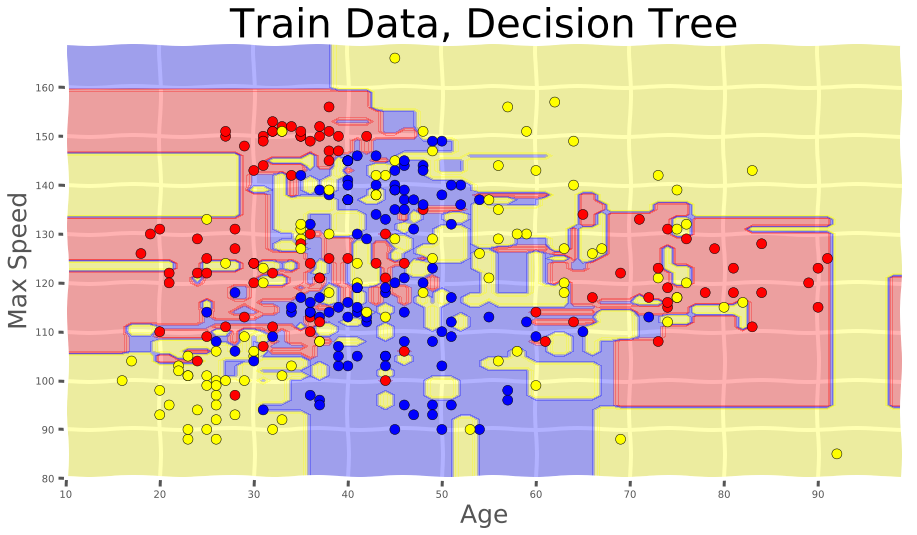

In [24]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Decision Tree");

In [25]:
clf.score(X_train_2_dim, y_train)

0.9425

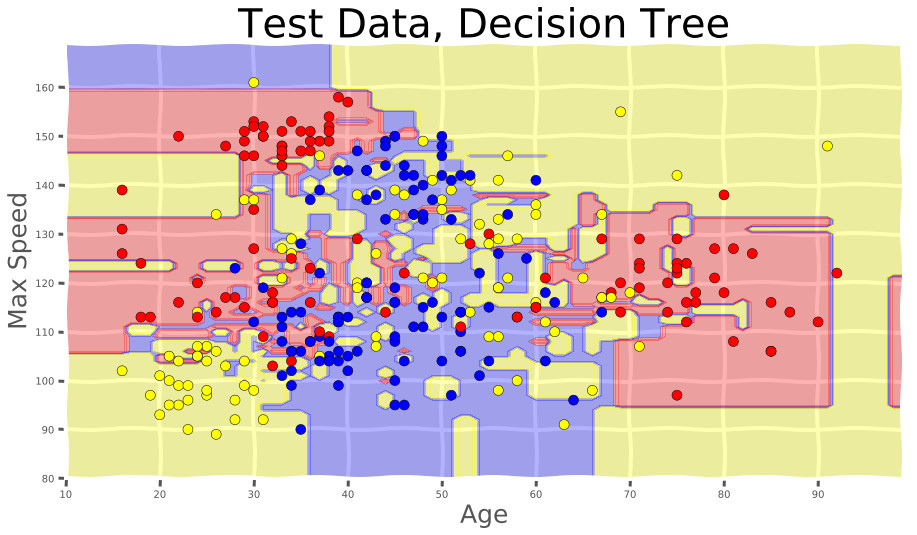

In [26]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree");

In [27]:
clf.score(X_test_2_dim, y_test)

0.6033333333333334

In [28]:
clf = DecisionTreeClassifier(max_depth=10)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 2.1 ms, sys: 40 µs, total: 2.14 ms
Wall time: 2.15 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [29]:
clf.tree_.max_depth

10

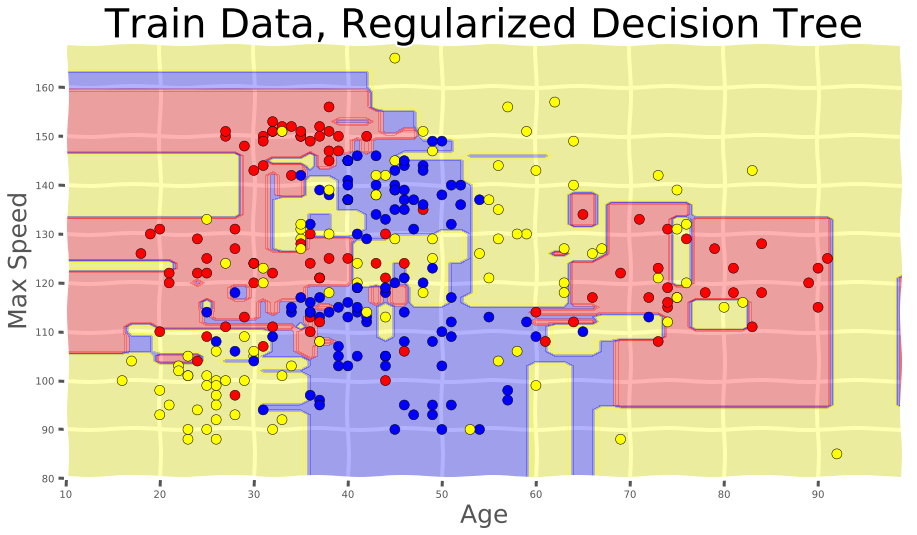

In [30]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Decision Tree");

In [31]:
clf.score(X_train_2_dim, y_train)

0.8291666666666667

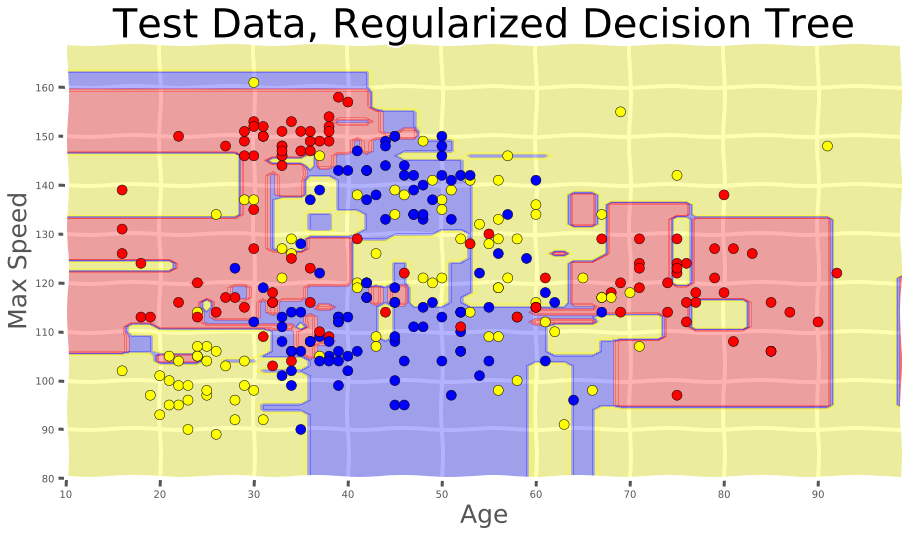

In [34]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Decision Tree");

In [36]:
clf.score(X_test_2_dim, y_test)

0.65